In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("data/daily_sales_french_bakery.csv", parse_dates=["ds"])
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)
df = df.drop(["unit_price"], axis=1)
df.head()

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


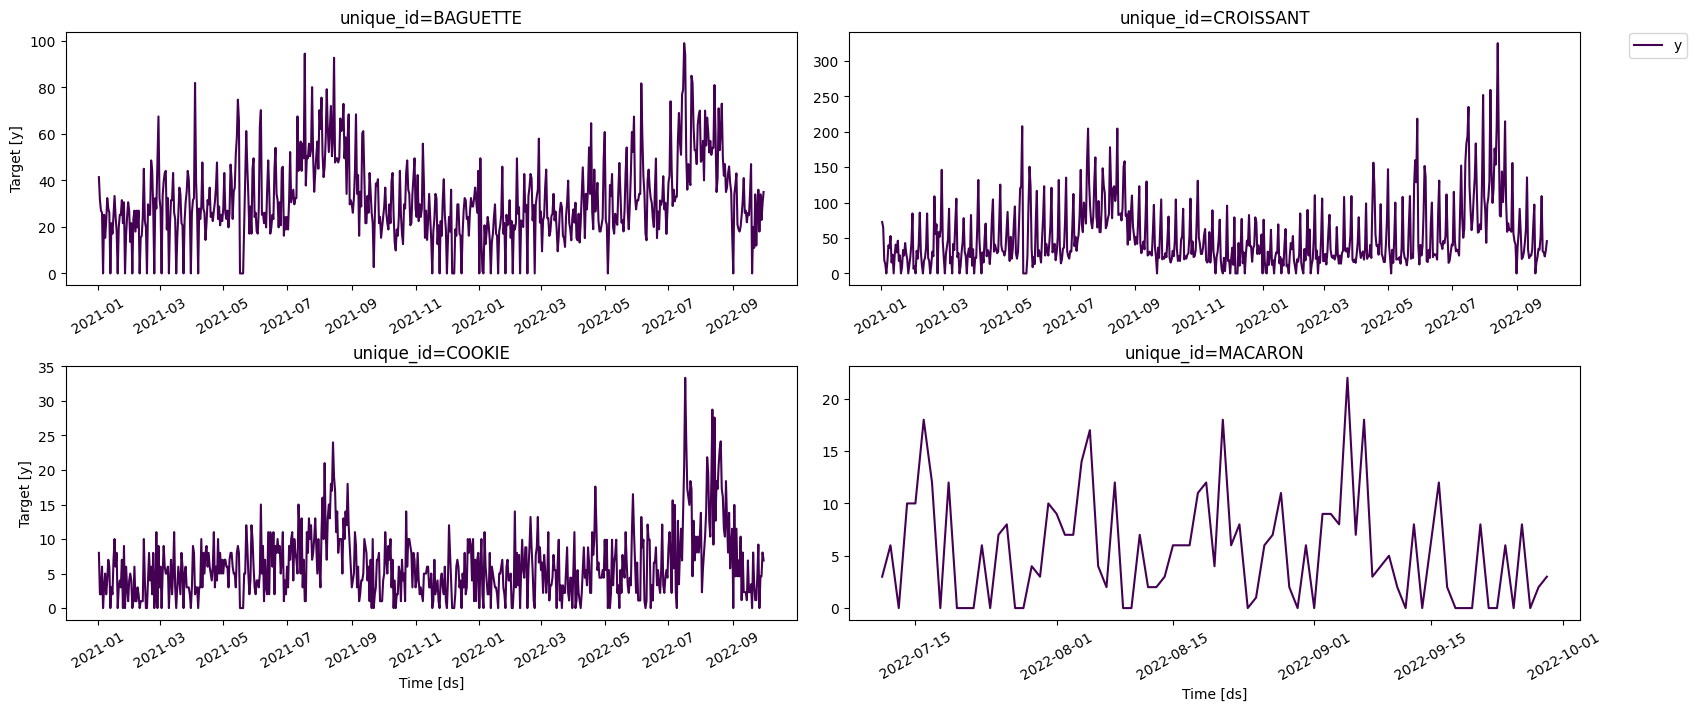

In [5]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT", "COOKIE", "MACARON"], palette="viridis")

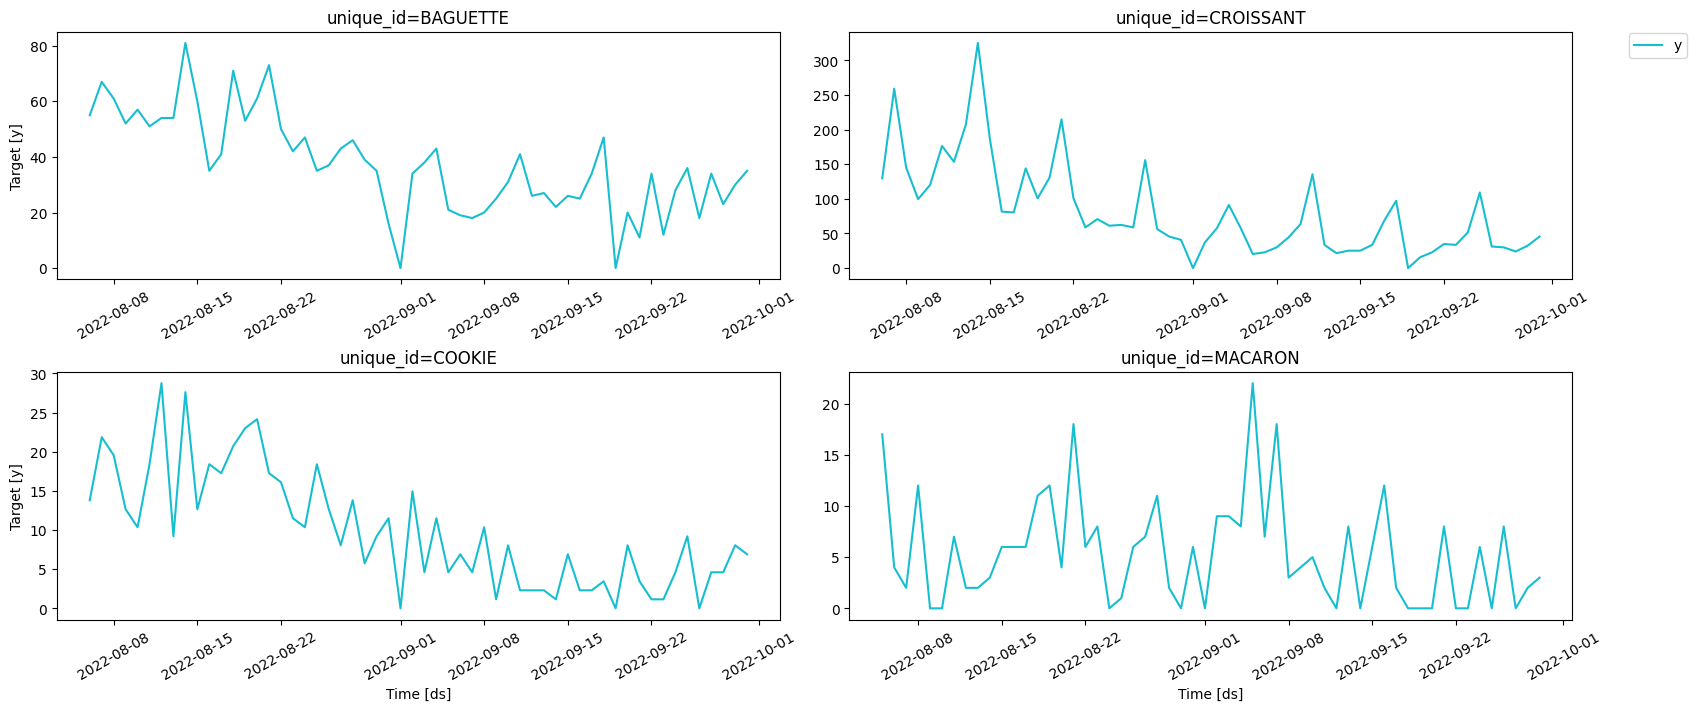

In [ ]:
plot_series(df=df, ids=["BAGUETTE", "CROISSANT", "COOKIE", "MACARON"], max_insample_length=56)
# last 56 time stamps

In [7]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive

In [8]:
horizon = 7 # daily data (7 days)

models = [
    Naive(), # last known timestep
    HistoricAverage(), # average of entire history
    WindowAverage(window_size=7), # calculate average of 7 days
    SeasonalNaive(season_length=7) # seasonality of data is 7 days
]

sf = StatsForecast(models=models, freq="D") # daily frequency
sf.fit(df=df)

prediction = sf.predict(h=horizon)

In [9]:
prediction.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


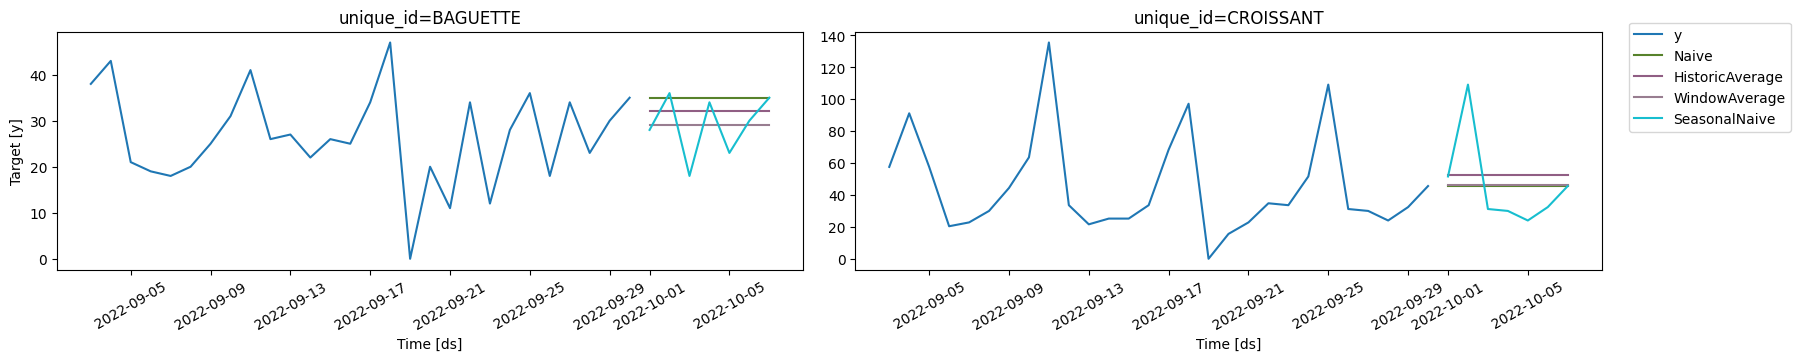

In [11]:
plot_series(
    df=df,
    forecasts_df=prediction,
    ids=["BAGUETTE", "CROISSANT"],
    max_insample_length=28
)

In [12]:
test = df.groupby("unique_id").tail(7)
train = df.drop(test.index).reset_index(drop=True)

In [14]:
sf.fit(df=train)
prediction = sf.predict(h=horizon)
eval_df = pd.merge(test, prediction, 'left', ['ds', 'unique_id'])

In [15]:
evaluation = evaluate(
    eval_df,
    metrics=[mae], 
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [17]:
evaluation = evaluation.drop('unique_id', axis=1).groupby('metric').mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636
